In [263]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv
import matplotlib.pyplot as plt
import os
import math
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
import time
import itertools
import random

# DTSA-5510: Unsupervised Learning Final Project

## Pneumonia Classification with Computer Vision

### Ethan Tucker, 6/19/2022

For my final project I wanted to expand my computer vision repetoir. Last term in supervised learning I did rice image classification from a very clean dataset with very standardized file names. I want to practice using the os.listdir() to programatically clean messy file names.

The data I will use can be found at [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/3). The data contain images of both chest X-Rays and Optical Coherence Tomography. I will use the chest X-rays in this project, but I think in another project I'll use the OCT data. 

Here's my general plan of attack:

1) Import and clean the data. I'll use PCA to reduce the image sizes for modelling purposes.

2) Perform an EDA. I'll do this on the untransformed data for human comprehensibility. I will allow the user to pick a feature to analyze!

3) Build unsupervised models. I'll use sklearn's library for two models: NMF, and KMeans. 

4) Compare against a supervised model. Because I wich to do this, I will be careful during data importation so that I can easily transition to a Random Forest.

## (1) Import and Clean the Data

First thing's first, I'll set my working directory to contain the pnuemonia images. Please adapt this line to work on your build.

In [169]:
%cd "C:/Users/first/Desktop/DTSA_5510_HW/Final_Project/data/chest_xray"

os.listdir()

C:\Users\first\Desktop\DTSA_5510_HW\Final_Project\data\chest_xray


['reducedData.csv', 'test', 'train']

#### Initial Data Inspections:

The chest X-ray data in "train" contains 1.18 GB of data - consisting of 5233 "normal" chest X-rays, 1345 X-rays with viral pnuemonia, and 2538 X-rays with bacterial pnuemonia. The "test" data contains 105 MB of data - there are 235 "normal" chest X-rays, 626 with viral pnuemonia, and 242 with bacterial pnuemonia. In the cell directly below I read in a single image and have python display it (if the data are properly located). As is shown by the output of that cell, each image is read in as a (2476, 2572) numpy array. There is a whole lot of data, so that loading will take a long time. If you don't want to wait that long, I include an option "pixDesired" in the loading function to allow lower accuracy in exchange for faster loads and trains.

**Important cleaning note:** not all of the images are the same dimension. As such please use the pixDesired option to standardize the images to a square of user defined shape. Ensure that this square is larger than the minimum pixel count. The auto selection of 1000 pixels per side does this if you don't want to do any cleaning yourself.

I will now build a function to load in the test and train data. I will then convert these to numpy arrays and perform a join. The image processing library I will use is cv2. I will keep track of the indecies for the training and test data, as well as the labels. The first "section" loaded in will be Normal Train, then Viral Train, then Bacterial Train, then Normal Test, then Viral Test, and finally Bacterial Test. For the supervised learning approach at the end I will use the indecies to assign labels.

**Important cleaning note:** the bacterial and viral infections are initially in the same folder, so I will make a new folder called "BACTERIAL" and "VIRAL" that contain those infections for labelling and diversification purposes. I do this in both the training and testing data. While it would probably suffice to randomly sample from the "PNUEMONIA" folder that existed, it would be difficult to reconstruct the labels (we would need to use the file name, and that's pretty dicey).

In [3]:
# Example XRay. Citation https://www.geeksforgeeks.org/python-opencv-cv2-imshow-method/
# Set file path
startTime = time.time()
repopath = "./train/" + "NORMAL/"
filepath = repopath + os.listdir(repopath)[0]

#Read in test image
testpic = cv.imread(filepath, 0)
#testpic = cv.resize(testpic, (256, 256))

endTime = time.time()

##Show test image
#testWindow = "Example XRAY. This is a healthy lung."
#cv.imshow(testWindow, testpic)
#cv.waitKey(0)  #Wait for the user to press a key before closing the window
#cv.destroyAllWindows() 

print(testpic.shape)
print(endTime - startTime)

(2476, 2572)
0.12372922897338867


In [4]:
# Function to read a file into numpy.
def readXRay(path, pixDesired = 1000, n_imgs = "use all"):
    """
        input: string path, of form ("./data/ os.listdir(parent directory)
        input: int pixDesired, the number of pixels pixDesired X pixDesired in which to read the data. If None, no transformation is performed.
        input: int n_imgs, number of images to be read from file. Preset is string "use all", which uses all the images in the provided path.
        output: np.ndarray data
    """
    
    # Initialize data
    firstImagePath = path + os.listdir(path)[0]
    firstPic = cv.imread(firstImagePath, 0)
    if pixDesired != None:
        data = cv.resize(firstPic, (pixDesired, pixDesired))
        data = data.reshape(1, pixDesired ** 2)# If performance allows, increase resize!
    else:
        data = data.reshape(1, firstPic.shape[0] * firstPic.shape[1])
    
    # Populate data
    
    if n_imgs == "use all":
        for img in os.listdir(path)[1:]:
            filepath = path + img
            pic = cv.imread(filepath, 0)
            if pixDesired != None:
                pic = cv.resize(pic, (pixDesired, pixDesired))
                pic = pic.reshape(1, pixDesired ** 2)
            else:
                pic = pic.reshape(1, pic.shape[0] * pic.shape[1])
            
            data = np.append(data, pic, axis = 0)
            
    else:
        for img in os.listdir(path)[1:n_imgs]:
            filepath = path + img
            pic = cv.imread(filepath, 0)
            if pixDesired != None:
                pic = cv.resize(pic, (pixDesired, pixDesired)) # If performance allows, increase resize!
                pic = pic.reshape(1, pixDesired ** 2)
            else:
                pic = pic.reshape(1, pic.shape[0] * pic.shape[1])
            
            data = np.append(data, pic, axis = 0)
        
    return(data)

In [5]:
# Set up paths of repositories to read data from
paths = ["./train/NORMAL/", "./train/VIRAL/", "./train/BACTERIAL/", "./test/NORMAL/", "./test/VIRAL/", "./test/BACTERIAL/"]

#Initialize data
firststartTime = time.time()
data = readXRay(path = paths[0], pixDesired = 100, n_imgs = "use all")
firstendTime = time.time()
print(firstendTime - firststartTime) #How long did this repo take to convert?
print(data.shape) #How many files in this repo?

#Populate data with the other repositories
for path in paths[1:]:
    startTime = time.time()
    this_data = readXRay(path = path, pixDesired = 100, n_imgs = "use all")
    endTime = time.time()

    print(endTime - startTime) #How long did this repo take to convert?
    print(this_data.shape) #How many files in this repo?
    data = np.append(data, this_data, axis = 0)

print(endTime - firststartTime)
print(data.shape)

27.264589309692383
(1349, 10000)
13.998448610305786
(1345, 10000)
29.164000034332275
(2538, 10000)
3.592069387435913
(234, 10000)
1.2073240280151367
(148, 10000)
1.703300952911377
(242, 10000)
76.97756552696228
(5856, 10000)


In [42]:
# Records 3 class labels in np.ndarray
Normal1 = np.asarray(["NORMAL" for i in range(1349)])
Viral1 = np.asarray(["VIRAL" for i in range(1345)])
Bacterial1 = np.asarray(["BACTERIAL" for i in range(2538)])
Normal2 = np.asarray(["NORMAL" for i in range(234)])
Viral2 = np.asarray(["VIRAL" for i in range(148)])
Bacterial2 = np.asarray(["BACTERIAL" for i in range(242)])
labs = np.append(Normal1, Viral1, axis = 0)
labs = np.append(labs, Bacterial1, axis = 0)
labs = np.append(labs, Normal2, axis = 0)
labs = np.append(labs, Viral2, axis = 0)
labs = np.append(labs, Bacterial2, axis = 0)

assert labs.shape[0] == data.shape[0]

print(labs.shape)

(5856,)


In [45]:
# Records 2 class labels in np.ndarray
Infected1 = np.asarray(["INFECTED" for i in range(1345 + 2538)])
Infected2 = np.asarray(["INFECTED" for i in range(148 + 242)])

labs2 = np.append(Normal1, Infected1, axis = 0)
labs2 = np.append(labs2, Normal2, axis = 0)
labs2 = np.append(labs2, Infected2, axis = 0)

assert labs2.shape[0] == data.shape[0]

print(labs2.shape)

(5856,)


Using pixDesired = 100 resulted in a total data reading time of 54 seconds. Using pixDesired = 500 resulted in a total time of 543 seconds, which is almost an order of magnitude increase on the dot.  An interesting project would be measuring accuracy vs. pixDesired over perhaps an order of magnitude of pixDesired. With the 500 pixDesired, we need an extra 10 GB of RAM to run the NMF, which is way too much. I'll stick with pixDesired = 100 for this project. Note that this will severly damage accuracy.

#### Perform PCA to reduce data to managable size

In [8]:
#Perform PCA. We will use a minimum explained variance of 0.98 so as to prevent inhibiting our models from successfully categorizing the X-Rays
min_var_explained = 0.98
pca = PCA(n_components = min_var_explained, svd_solver = "full")

startTime = time.time()
reducedData = pca.fit_transform(data)
endTime = time.time()

# Print result summary
print(endTime - startTime)
print(reducedData.shape)

93.30349373817444
(5856, 1533)


In [9]:
#Write the resulting data to a csv so that we don't need to process it again in future analysis
startTime = time.time()
np.savetxt("reducedData.csv", reducedData, delimiter=",")
endTime = time.time()
print(endTime - startTime)

7.385784864425659


# (2) Perform EDA

The features of the individual data are individual pixels read in greyscale. The values thus range from 0 to 255 ($2^8$ brightness options). I will have python make histograms of the max, min, and mean values for each feature in the original dataset. I will also plot the standard deviations.

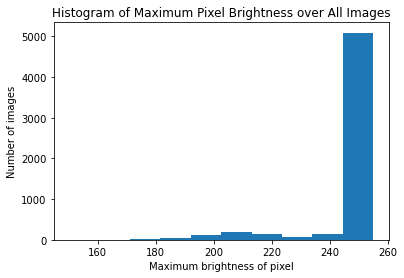

In [14]:
# Make histogram of max values
maxes = list(np.max(data, axis = 1))
plt.hist(maxes)
plt.xlabel("Maximum brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Maximum Pixel Brightness over All Images")
plt.show()

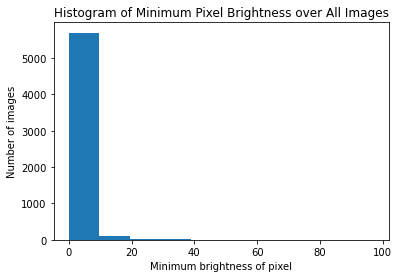

In [15]:
mins = np.min(data, axis = 1)
plt.hist(mins)
plt.xlabel("Minimum brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Minimum Pixel Brightness over All Images")
plt.show()

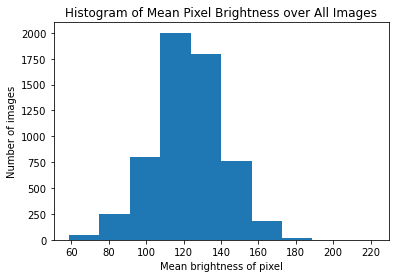

In [16]:
means = np.mean(data, axis = 1)
plt.hist(means)
plt.xlabel("Mean brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Mean Pixel Brightness over All Images")
plt.show()

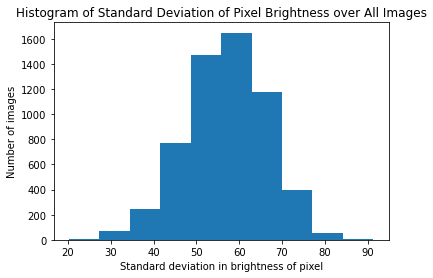

In [17]:
stds = np.std(data, axis = 1)
plt.hist(stds)
plt.xlabel("Standard deviation in brightness of pixel")
plt.ylabel("Number of images")
plt.title("Histogram of Standard Deviation of Pixel Brightness over All Images")
plt.show()

While I would like to create a correlation matrix, there are $10000$ pixels per image, and about $5000$ images. The construction of a correlation matrix would include the comparison of *every single pixel with every other pixel*. That's $(10^4 \times 5 \times 10^3)^2$ comparisons, resulting in a the order of  $5 \times 10^{49}$ operations. That's approaching the number of particles in the solar system. One correlation calcualation takes my computer $10^{-3}$ seconds. Over $5000^2$ calculations a full correlation calculation would take about $7$ hours. Clearly we can't do that. Instead, I'll allow the user to calculate the correlation between any two pixels **of their choice**.

In [18]:
# Make function to allow user to determine correlation between two features
def getCorr(data, pix1, pix2):
    """
        input: np.ndarray data
        input: int pix1
        input: int pix2
    """
    # Build an (n, 2) np.ndarray to hold observations of pix1 and pix2
    pix1vals = data[:, pix1]
    pix1vals = pix1vals.reshape((pix1vals.shape[0], 1))
    pix2vals = data[:, pix2].reshape((pix1vals.shape[0], 1))
    corrdata = np.append(pix1vals, pix2vals, axis = 1)
    #Calculate correlation
    corr = np.corrcoef(corrdata, rowvar = False)[0, 1]
    return(corr)

startTime = time.time()
testCorr = getCorr(data, 12, 1223)
endTime = time.time()
print(endTime - startTime)
print(testCorr)

0.01801586151123047
0.47032254948509544


### A little EDA on the reduced data

After performing PCA on the image data, the new features are coordinates in the new dimensions where we use the eigenvectors of the principal components as basis vectors. As such they lose human comprehensibility. I will print out the histograms of min, max, mean, and standard deviation, but do note they don't have easy translations in the new space. Also feel free to play with the getCorr() function on the reduced data - it will still work! Just swap out data for reducedData.

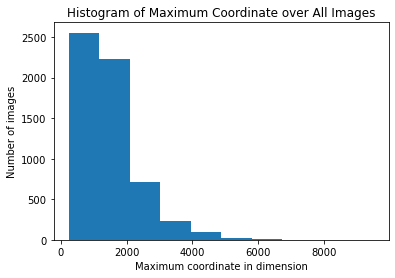

In [19]:
# Make histogram of max values
maxes = list(np.max(reducedData, axis = 1))
plt.hist(maxes)
plt.xlabel("Maximum coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Maximum Coordinate over All Images")
plt.show()

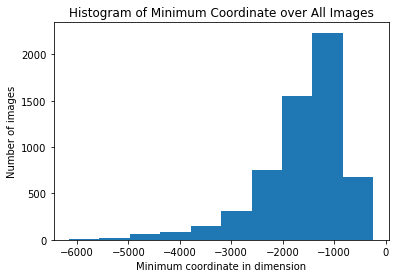

In [20]:
# Make histogram of min values
mins = np.min(reducedData, axis = 1)
plt.hist(mins)
plt.xlabel("Minimum coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Minimum Coordinate over All Images")
plt.show()

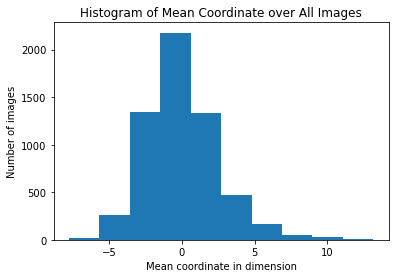

In [21]:
# Make histogram of min values
means = np.mean(reducedData, axis = 1)
plt.hist(means)
plt.xlabel("Mean coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Mean Coordinate over All Images")
plt.show()

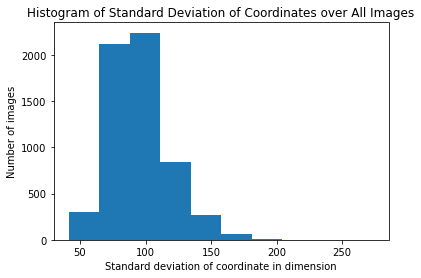

In [22]:
# Make histogram of standard deviations
# Make histogram of min values
stds = np.std(reducedData, axis = 1)
plt.hist(stds)
plt.xlabel("Standard deviation of coordinate in dimension")
plt.ylabel("Number of images")
plt.title("Histogram of Standard Deviation of Coordinates over All Images")
plt.show()

# (3) Make Unsupervised Models

## NMF:

NMF is a great first attack at categorizing the data, because there are no missing values in the rectangular data matrix. Unfortunately the reducedData has negative values as can be seen in the EDA, so we must use NMF on the original dataset. This model will probably take the longest to train because we have the most features. It also has the best chance of being accurate, because we aren't limiting the explained variance to 0.98. I'll do an SVD on the reducedData afterwards and compare against the NMF. I will use n_components = 3 for all my unsupervised models, representing Normal, Viral, and Bacterial chest X-Rays. I will do a couple hyperparameter choices, and compare models by classification accuracy / recall / precision.

#### L2 Loss: 3 categories

In [69]:
# Finalize predictions from NMF.fit_transform()
def finalizePredictions(W):
    """
        input: numpy.ndarray W (e.g. output of NMF.fit_transform())
        output: numpy.ndarray predictions
    """
    predictions = np.zeros(shape = (W.shape[0]))
    n_rows = W.shape[0]
    n_cols = W.shape[1]
    
    for i in range(n_rows):
        current_best = (None, 0) # current_best is of form (column number, highest weight)
        for j in range(n_cols):
            if W[i, j] > current_best[1]:
                current_best = (j, W[i, j])
        
        if current_best[0] == None:
            print("Something bad happened")
            
        predictions[i] = current_best[0]
    
    return(predictions.astype(int))

# Create label reconstructor using a best subset algorithm
def reconstructLabels(pred, trueLabs):
    """
        input: np.ndarray pred of shape (n_images, )
        input np.ndarray trueLabs of shape (n_images, )
        output: np.ndarray yhat of shape (n_images, )
    """
    n = pred.shape[0]
    categories = list(np.unique(trueLabs))
    permutations = list(itertools.permutations(categories))
    
    currentBest = (None, float("inf"))
    
    for subset in permutations:
        n_misclassified = 0
        for i in range(n):
            if subset[int(pred[i])] != trueLabs[i]:
                n_misclassified = n_misclassified + 1
        if n_misclassified < currentBest[1]:
            currentBest = (subset, n_misclassified)
    
    return(currentBest)

In [50]:
# Create NMF model on originals data. I will compare a few hyperparameter choices.
nmf_model_1 = NMF(n_components = 3, beta_loss = "frobenius", init = 'nndsvd', solver = "cd", max_iter = 1000)
startTime = time.time()
W_1 = nmf_model_1.fit_transform(data)
endTime = time.time()
print(endTime - startTime)

C:\Users\first\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


49.66877460479736


In [170]:
# Convert predictions into a form that sklearn will accept
yhat1 = finalizePredictions(W_1)
categoryNames = reconstructLabels(yhat1, labs)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [171]:
# Print out confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat1))

[[1793   52  935]
 [1126  350  107]
 [1138   67  288]]


In [172]:
# Compute accuracy, precision, and recall
print("The L2 NMF with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat1))
print("The L2 NMF with 3 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat1, average = "weighted"))
print("The L2 NMF with 3 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat1, average = "weighted"))

The L2 NMF with 3 categories had accuracy: 0.415129781420765
The L2 NMF with 3 categories had weighted average precision: 0.4667463436674939
The L2 NMF with 3 categories had weighted average recall: 0.415129781420765


#### L2 Loss: 2 categories

In [88]:
# Create NMF model on originals data. I will compare a few hyperparameter choices.
nmf_model_2 = NMF(n_components = 2, beta_loss = "frobenius", init = 'nndsvd', solver = "cd", max_iter = 1000)
startTime = time.time()
W_2 = nmf_model_2.fit_transform(data)
endTime = time.time()
print(endTime - startTime)

C:\Users\first\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


48.51993489265442


In [173]:
# Convert predictions into a form that sklearn will accept
yhat2 = finalizePredictions(W_2)
categoryNames = reconstructLabels(yhat2, labs2)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [174]:
# Print out confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat2))

[[4131  142]
 [1515   68]]


In [175]:
# Compute accuracy, precision, and recall
print("The L2 NMF with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat2))
print("The L2 NMF with 2 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat2, average = "weighted"))
print("The L2 NMF with 2 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat2, average = "weighted"))

The L2 NMF with 2 categories had accuracy: 0.7170423497267759
The L2 NMF with 2 categories had weighted average precision: 0.6214155927334378
The L2 NMF with 2 categories had weighted average recall: 0.7170423497267759


#### KL Loss: 3 categories

In [73]:
# Create NMF model on originals data. I will compare a few hyperparameter choices.
nmf_model_3 = NMF(n_components = 3, beta_loss = "kullback-leibler", init = 'nndsvdar', solver = "mu", max_iter = 100)
startTime = time.time()
W_3 = nmf_model_3.fit_transform(data)
endTime = time.time()
print(endTime - startTime)

C:\Users\first\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


97.34066414833069


In [176]:
# Convert predictions into a form that sklearn will accept
yhat3 = finalizePredictions(W_3)
categoryNames = reconstructLabels(yhat3, labs)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [177]:
# Print out confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat3))

[[2645    2  133]
 [1560   15    8]
 [1457    2   34]]


In [178]:
# Compute accuracy, precision, and recall
print("The KL NMF with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat3))
print("The KL NMF with 3 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat3, average = "weighted"))
print("The KL NMF with 3 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat3, average = "weighted"))

The KL NMF with 3 categories had accuracy: 0.4600409836065574
The KL NMF with 3 categories had weighted average precision: 0.48471325021487593
The KL NMF with 3 categories had weighted average recall: 0.4600409836065574


#### KL Loss: 2 Categories

In [92]:
# Create NMF model on originals data. I will compare a few hyperparameter choices.
nmf_model_4 = NMF(n_components = 2, beta_loss = "kullback-leibler", init = 'nndsvdar', solver = "mu", max_iter = 100)
startTime = time.time()
W_4 = nmf_model_4.fit_transform(data)
endTime = time.time()
print(endTime - startTime)

C:\Users\first\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


98.88731551170349


In [179]:
# Convert predictions into a form that sklearn will accept
yhat4 = finalizePredictions(W_4)
categoryNames = reconstructLabels(yhat4, labs2)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [180]:
# Print out confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat4))

[[4210   63]
 [1564   19]]


In [181]:
# Compute accuracy, precision, and recall
print("The KL NMF with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat4))
print("The KL NMF with 2 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat4, average = "weighted"))
print("The KL NMF with 2 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat4, average = "weighted"))

The KL NMF with 2 categories had accuracy: 0.7221653005464481
The KL NMF with 2 categories had weighted average precision: 0.5946666110429168
The KL NMF with 2 categories had weighted average recall: 0.7221653005464481


#### Commentary:

Wow those models sucked. Hopefully that isn't an indication of things to come. I had to limit the number of iterations the KL-solver to improve execution time so that we aren't waiting forever for convergance, but as a downside the models suffer. The unsupervised algorithm doesn't know that the three categories have different prevalence in the data, so we would expect an accuracy of $33\%$ as baseline. At least the models picked up some disease!The KL model better accuracy and recall, but the L2-Loss outperformed the KL-Loss surprisingly on precision. 

One consideration is that the NMF is detecting stronger groupings than Normal / Virus / Bacteria. It may be detecting relative lung sizes (child / teen / adult), bone configurations, etc. Regardless, the NMF models are *marginally* useful at detecting pneumonia.

## K-Means:

K-means is a great algorithm that is easily human-comprehensible. The idea is to place some number of clusters in the feature space, and iterate their position until they are as close to as many points as possible. We will specify there to be 3 centroids, for the same reason we factored the full data into $(n_{\text{images}}, 3) \times (3, n_{\text{pixels}})$; we want the algorithm to realize that there are normal xrays, bacterial infected xrays, and viral infected xrays. We will likely run into the same problem as in NMF, where we end up identifying trends other than pneumonia status. I will try using the two different algorithms in sklearn: "lloyd" and "elkan" and compare results.

#### Lloyd: 3 Categories

In [114]:
# Initialize Lloyd K-Means, and build predictions.
lloyd = KMeans(n_clusters = 3, random_state = 42, max_iter = 100, algorithm = "full")
startTime = time.time()
lloydModel = lloyd.fit_transform(reducedData)
endTime = time.time()
print(endTime - startTime)

1.8917148113250732


In [184]:
# Convert predictions into a form that sklearn will accept
yhat5 = finalizePredictions(lloydModel)
categoryNames = reconstructLabels(yhat5, labs)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [185]:
# Print out confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat5))

[[1488 1260   32]
 [ 671  906    6]
 [ 626  850   17]]


In [186]:
# Compute accuracy, precision, and recall
print("The Lloyd KMeans with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat5))
print("The Lloyd KMeans with 3 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat5, average = "weighted"))
print("The Lloyd KMeans with 3 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat5, average = "weighted"))

The Lloyd KMeans with 3 categories had accuracy: 0.41171448087431695
The Lloyd KMeans with 3 categories had weighted average precision: 0.41364943884947114
The Lloyd KMeans with 3 categories had weighted average recall: 0.41171448087431695


#### Lloyd: 2 Categories

In [100]:
# Initialize Lloyd K-Means, and build predictions.
lloyd2 = KMeans(n_clusters = 2, random_state = 42, max_iter = 100, algorithm = "full")
startTime = time.time()
lloydModel2 = lloyd2.fit_transform(reducedData)
endTime = time.time()
print(endTime - startTime)

1.223311424255371


In [187]:
# Convert predictions into a form that sklearn will accept
yhat6 = finalizePredictions(lloydModel2)
categoryNames = reconstructLabels(yhat6, labs2)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [188]:
# Print out confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat6))

[[ 825  758]
 [2006 2267]]


In [189]:
# Compute accuracy, precision, and recall
print("The Lloyd KMeans with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat6))
print("The Lloyd KMeans with 2 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat6, average = "weighted"))
print("The Lloyd KMeans with 2 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat6, average = "weighted"))

The Lloyd KMeans with 2 categories had accuracy: 0.5280054644808743
The Lloyd KMeans with 2 categories had weighted average precision: 0.6256130931833802
The Lloyd KMeans with 2 categories had weighted average recall: 0.5280054644808743


#### Elkan: 3 Categories

In [118]:
# Initialize Elkan K-Means, and build predictions.
elkan = KMeans(n_clusters = 3, random_state = 42, max_iter = 1000, algorithm = "elkan")
startTime = time.time()
elkanModel = elkan.fit_transform(reducedData)
endTime = time.time()
print(endTime - startTime)

1.3580563068389893


In [190]:
# Convert predictions into a form that sklearn will accept
yhat7 = finalizePredictions(elkanModel)
categoryNames = reconstructLabels(yhat7, labs)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [191]:
# Print out confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat7))

[[1488 1260   32]
 [ 671  906    6]
 [ 626  850   17]]


In [192]:
# Compute accuracy, precision, and recall
print("The Elkan KMeans with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat7))
print("The Elkan KMeans with 3 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat7, average = "weighted"))
print("The Elkan KMeans with 3 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat7, average = "weighted"))

The Elkan KMeans with 3 categories had accuracy: 0.41171448087431695
The Elkan KMeans with 3 categories had weighted average precision: 0.41364943884947114
The Elkan KMeans with 3 categories had weighted average recall: 0.41171448087431695


#### Elkan: 2 Categories

In [110]:
# Initialize Elkan K-Means, and build predictions.
elkan2 = KMeans(n_clusters = 2, random_state = 42, max_iter = 1000, algorithm = "elkan")
startTime = time.time()
elkanModel2 = elkan2.fit_transform(reducedData)
endTime = time.time()
print(endTime - startTime)

0.8896005153656006


In [193]:
# Convert predictions into a form that sklearn will accept
yhat8 = finalizePredictions(elkanModel2)
categoryNames = reconstructLabels(yhat8, labs2)

newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1
}
for label in labs2:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [194]:
# Print out confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhat8))

[[ 825  758]
 [2006 2267]]


In [195]:
# Compute accuracy, precision, and recall
print("The Elkan KMeans with 2 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhat8))
print("The Elkan KMeans with 2 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhat8, average = "weighted"))
print("The Elkan KMeans with 2 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhat8, average = "weighted"))

The Elkan KMeans with 2 categories had accuracy: 0.5280054644808743
The Elkan KMeans with 2 categories had weighted average precision: 0.6256130931833802
The Elkan KMeans with 2 categories had weighted average recall: 0.5280054644808743


### Commentary:

My suspiscion that we are categorizing something other than disease is increasing. The confusion matricies between the elkan and lloyd algorithms are essentially identical, which means that there are real categories that KMeans has discovered that are present in the chest X-Rays. My best guesses are patient size, shape, bone structure, race, etc. We would need to use these labels on a bunch of different labelled training data to figure out what the clusters represent. I suppose that's why we consider the point of Unsupervised Learning to find hidden trends that the data analyst didn't expect! That said, the models do have some predictive power over pneumonia, so whatever clusters are being discovered are at least correlated with pneumonia (or likeliness to develop pnuemonia).

# (4) Compare against a supervised model:

I'll use the training data (rows 0 through 5231) to try to predict the labels of the test data (the rest of the rows). It is fair to use the PCA transformed reduced-data, because the PCA did not know the labels of the data during transformation. As such the reducedData does not have any additional predictive power over the initial data, it just runs faster. In fact it will be on average worse, because we only account choose to account for 0.98 of the variance across all images. I will use a Random Forest for speed and accuracy. Please adjust n_jobs to allow for execution on your machine.

#### 3 Categories:

In [222]:
n_train = 5232
startTime = time.time()
forest = RandomForestClassifier(n_estimators = 10000, random_state = 42, n_jobs = 14).fit(reducedData[:5232, :], labs[:5232])
endTime = time.time()
print(endTime - startTime)
yhat9 = forest.predict(reducedData[5232: , :])

296.18887090682983


In [223]:
print(confusion_matrix(y_true = labs[5232: ], y_pred = yhat9))

[[234   8   0]
 [119 115   0]
 [130  12   6]]


In [224]:
# Compute accuracy, precision, and recall
print("The Random Forest with 3 categories had accuracy:" , accuracy_score(y_true = labs[5232: ], y_pred = yhat9))
print("The Random Forest with 3 categories had weighted average precision:", precision_score(y_true = labs[5232: ], y_pred = yhat9, average = "weighted"))
print("The Random Forest with 3 categories had weighted average recall:", recall_score(y_true = labs[5232: ], y_pred = yhat9, average = "weighted"))

The Random Forest with 3 categories had accuracy: 0.5689102564102564
The Random Forest with 3 categories had weighted average precision: 0.7445121303816956
The Random Forest with 3 categories had weighted average recall: 0.5689102564102564


In [228]:
#### 2 Categories:
startTime = time.time()
forest = RandomForestClassifier(n_estimators = 10000, random_state = 42, n_jobs = 14).fit(reducedData[:5232, :], labs2[:5232])
endTime = time.time()
print(endTime - startTime)
yhat10 = forest.predict(reducedData[5232: , :])

266.91250491142273


In [229]:
print(confusion_matrix(y_true = labs2[5232: ], y_pred = yhat10))

[[384   6]
 [197  37]]


In [231]:
# Compute accuracy, precision, and recall
print("The Random Forest with 2 categories had accuracy:" , accuracy_score(y_true = labs2[5232: ], y_pred = yhat10))
print("The Random Forest with 2 categories had weighted average precision:", precision_score(y_true = labs2[5232: ], y_pred = yhat10, average = "weighted"))
print("The Random Forest with 2 categories had weighted average recall:", recall_score(y_true = labs2[5232: ], y_pred = yhat10, average = "weighted"))

The Random Forest with 2 categories had accuracy: 0.6746794871794872
The Random Forest with 2 categories had weighted average precision: 0.7357553136132571
The Random Forest with 2 categories had weighted average recall: 0.6746794871794872


# 5: Conclusion, Discussion, and Results Summary Table

By now it seems that the unsupervised models were seeing something it considered more prominent than infected vs. non infected lungs in the chest X-Rays. To determine whether the clusters are similar, let's compare them! I'll make a cosine-similarity matrix using sklearn, then map the domain of values to $[0, 1]$ using the following formula presented in class:

$$ \text{sim}(\vec{y_1}, \vec{y_2}) = 0.5 + 0.5 * \text{Pearson}(\vec{y_1}, \vec{y_2})$$

In [259]:
# Correlation matrix to compare similarity over predictions for 3 category models
yhatAll3Categories = np.vstack((
    yhat1.reshape(1, yhat1.shape[0]),
    yhat3.reshape(1, yhat3.shape[0]),
    yhat5.reshape(1, yhat5.shape[0]),
    yhat7.reshape(1, yhat7.shape[0]))
)

cosineMatrix = cosine_similarity(yhatAll3Categories)
print(.5 + .5 * cosineMatrix)

[[1.         0.67596578 0.79319435 0.79319435]
 [0.67596578 1.         0.58784885 0.58784885]
 [0.79319435 0.58784885 1.         1.        ]
 [0.79319435 0.58784885 1.         1.        ]]


We would expect a similarity metric of $0.333$ if there was no correlation between any two clusters because there are three categories. The correlations are much higher than that; all models had something in common. As such we might think to bag the models and use the consensus opinion. Because models 5 and 7 had a perfect correlation (the K-Means models), we need to exlude one for the bagging to work. Let's try that and see how that affects accuracy:

In [280]:
# Take out perfectly correlated prediction yhat7
yhatMost3Categories = np.vstack((
    yhat1.reshape(1, yhat1.shape[0]),
    yhat3.reshape(1, yhat3.shape[0]),
    yhat5.reshape(1, yhat5.shape[0])
))

def majorityRule3(predictionMatrix):
    """
        input: np.ndarray predictionMatrix of shape (n_models, n_images)
        output: np.ndarray baggedPred of shape (n_images, )
    """
    # The algorithm we will use is to pick the mode if possible, then break ties randomly.    baggedPred = np.zeros(predictionMatrix.shape[1]).astype(int)
    #Populate baggedPred
    for j in range(predictionMatrix.shape[1]):
        counts = {
            0: 0,
            1: 0,
            2: 0
        }
        #Populate counts
        for i in range(predictionMatrix.shape[0]):
            this_prediction = predictionMatrix[i, j]
            counts.update({this_prediction : counts[this_prediction] + 1})
        #Determine the winner
        if counts[0] > counts[1] and counts[0] > counts[2]:
            baggedPred[j] = 0
        elif counts[1] > counts[0] and counts[1] > counts[2]:
            baggedPred[j] = 1
        elif counts[2] > counts[0] and counts[2] > counts[1]:
            baggedPred[j] = 2
        else: # Break ties randomly
            tieBreaker = random.random()
            # There are three rows, so there can be a three way tie. We will flip a coin to pick the winner.
            if counts[0] == counts[1] and counts[0] > counts[2]:
                assert counts[1] > counts[2]
                if tieBreaker < .5:
                    baggedPred[j] = 0
                else:
                    baggedPred[j] = 1
            elif counts[0] == counts[2] and counts[0] > counts[1]:
                assert counts[2] > counts[1]
                if tieBreaker < .5:
                    baggedPred[j] = 0
                else:
                    baggedPred[j] = 2
            elif counts[1] == counts[2] and counts[1] > counts[0]:
                assert counts[2] > counts[0]
                if tieBreaker < .5:
                    baggedPred[j] = 1
                else:
                    baggedPred[j] = 2
            else:
                # 3 Way Tie
                assert counts[1] == counts[2] and counts[2] == counts[0]
                if tieBreaker < 1/3:
                    baggedPred[j] = 0
                elif tieBreaker < 2/3:
                    baggedPred[j] = 1
                else:
                    baggedPred[j] = 2

    return(baggedPred)

In [279]:
# Get Bagged Predictions
yhatBagged3 = majorityRule3(yhatMost3Categories)

# Convert Labels to a form sklearn will like
categoryNames = reconstructLabels(yhatBagged3, labs)
newlabs = list()
labelDictionary = {
    categoryNames[0][0] : 0,
    categoryNames[0][1] : 1,
    categoryNames[0][2] : 2
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

# Print confusion matrix
print(confusion_matrix(y_true = newlabs, y_pred = yhatBagged3))

# Compute accuracy, precision, and recall
print("The Bagged Model with 3 categories had accuracy:" , accuracy_score(y_true = newlabs, y_pred = yhatBagged3))
print("The Bagged Model with 3 categories had weighted average precision:", precision_score(y_true = newlabs, y_pred = yhatBagged3, average = "weighted"))
print("The Bagged Model with 3 categories had weighted average recall:", recall_score(y_true = newlabs, y_pred = yhatBagged3, average = "weighted"))

[[2215  245  320]
 [1202  338   43]
 [1259  118  116]]
The Bagged Model with 3 categories had accuracy: 0.4557718579234973
The Bagged Model with 3 categories had weighted average precision: 0.41695823951619526
The Bagged Model with 3 categories had weighted average recall: 0.4557718579234973


In the bagged model, the metrics went up a little bit compared to the L2-Loss NMF and the K-Means models, but were still worse than the KL-Loss NMF. It seems that the L2-Loss NMF and K-Means models saw some consistently different clusters in the data than pneumonia status, whereas KL-Loss NMF saw more pneumonia. As such the bagged model destructively interferes with itself, losing a little in metrics. 

It is worth noting that the supervised model (which is the gold standard in predicting labels) had a pretty poor performance too, even though I gave it a VERY long time to train. The L2-Loss NMF and K2-Loss NMF both beat the Random Forest for 2 Category classification in accuracy and recall! That said, they both performed quite a bit worse in precision. The bad performance of all models shows a couple truths: (1) There is inherent difficulty in detecting pneumonia in X-Rays. I guess that's why people need medical degrees to do it for a living! (2) 5000 images is not enough to teach a machine how to read a chest X-Ray for pneumonia. I'd like to repeat the project with an extra order of magnitude of data.

#### Here's my results summary for the 3 Category Models:

| 3 Categories  | Accuracy | Precision | Recall |
|---------------|----------|-----------|--------|
| L2-Loss NMF   | 0.4151   | 0.4667    | 0.4151 |
| KL-Loss NMF   | 0.4600   | 0.4847    | 0.4600 |
| Lloyd KMeans  | 0.4136   | 0.4136    | 0.4117 |
| Elkan KMeans  | 0.4117   | 0.4136    | 0.4117 |
| Bagged        | 0.4558   | 0.4170    | 0.4558 |
| Random Forest | 0.5689   | 0.7445    | 0.5689 |

#### Here's my results summary for the 2 Category Models:

| 2 Categories  | Accuracy | Precision | Recall |
|---------------|----------|-----------|--------|
| L2-Loss NMF   | 0.7170   | 0.6214    | 0.7170 |
| KL-Loss NMF   | 0.7222   | 0.5947    | 0.7222 |
| Lloyd KMeans  | 0.5280   | 0.6256    | 0.5280 |
| Elkan KMeans  | 0.5280   | 0.6256    | 0.5280 |
| Random Forest | 0.6746   | 0.7358    | 0.6747 |

A good way to try and improve the unsupervised models would be to isolate the lungs away from the rest of the body in the X-Rays before feeding the data into the models. I'm not sure how I would go about doing this; I might need yet another layer of supervised models that know lungs apart from the rest of the body. I think that would be a good master's thesis-level project.

In this project I practiced importing, cleaning, and reducing image data. I played with 8 unsupervised learning models, and built custom functions to reconstruct labels and try to figure out what the algorithms were seeing. The algorithms had consistent clusterings as is evidenced by the similarity matrix earlier in this section. I wonder what they were seeing if not pneumonia. Sex? Bone damage? Age groups? There are really any number of human comprehensible clustering options, and even more non-human comprehensible ones. There is no guarentee that the unsupervised models are going to do what you expect - I suppose that's the primary take away from this project. Unsupervised models are designed to find trends that a data analyst wouldn't. It is then the data analyst's job to figure out what the groupings are post-defacto. 

# Bibliography

1) [Data repository](https://data.mendeley.com/datasets/rscbjbr9sj/3)

2) [Past Research on Subject](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

3) Requested Citation: Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images”, Mendeley Data, V3, doi: 10.17632/rscbjbr9sj.3

4) [Usage of cv2](https://www.geeksforgeeks.org/python-opencv-cv2-imshow-method/)

